## Medusa test with dummy foreground and premise background

In [1]:
import sys
import os
import bw2data as bd
import bw2calc as bc
import bw2io as bi
from bw_temporalis import TemporalDistribution
sys.path.append(os.path.realpath('../'))
import numpy as np

In [2]:
PROJECT_NAME = "bw25_premise_background_v2"
RESET= False

if PROJECT_NAME in bd.projects and not RESET: # use existing project
    print("Using existing project: {}".format(PROJECT_NAME))
    bd.projects.set_current(PROJECT_NAME)
    
else: # create project from scratch
    print("Creating new project: {}".format(PROJECT_NAME))
    if PROJECT_NAME in bd.projects:
        bd.projects.delete_project(PROJECT_NAME)
    bi.backup.restore_project_directory(r'filepath/to/backup/directory') # tar file shared on slack
    bd.projects.set_current(PROJECT_NAME)
    
bd.databases

Using existing project: bw25_premise_background_v2


Databases dictionary with 6 object(s):
	biosphere3
	cutoff39
	db_2020
	db_2030
	db_2040
	foreground

In [3]:
# prospective databases were generated with premise, updating only electricity
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

Select electricity process in dbs

In [4]:
db_2030.search("market group for electricity, high voltage WEU")

['market group for electricity, high voltage' (kilowatt hour, WEU, None),
 'market group for electricity, high voltage, 20-year period' (kilowatt hour, WEU, None),
 'market group for electricity, high voltage, 40-year period' (kilowatt hour, WEU, None),
 'market group for electricity, high voltage, 60-year period' (kilowatt hour, WEU, None)]

In [5]:
#selecting Western Europe's electricity market mix as
electr_WEU_2020 = [x for x in db_2020 if (x['name'] == 'market group for electricity, high voltage' and "period"not in x["name"] and x["location"] == "WEU" )][0]
electr_WEU_2020


'market group for electricity, high voltage' (kilowatt hour, WEU, None)

In [6]:
electr_WEU_2030 = [x for x in db_2030 if (x['name'] == 'market group for electricity, high voltage' and "period"not in x["name"] and x["location"] == "WEU")][0]
electr_WEU_2030.as_dict()

electr_WEU_2040 = [x for x in db_2040 if (x['name'] == 'market group for electricity, high voltage' and "period"not in x["name"] and x["location"] == "WEU")][0]



In [7]:
bd.get_activity((electr_WEU_2020["database"],electr_WEU_2020["code"]))

'market group for electricity, high voltage' (kilowatt hour, WEU, None)

Flow chart of system:<br> <br> 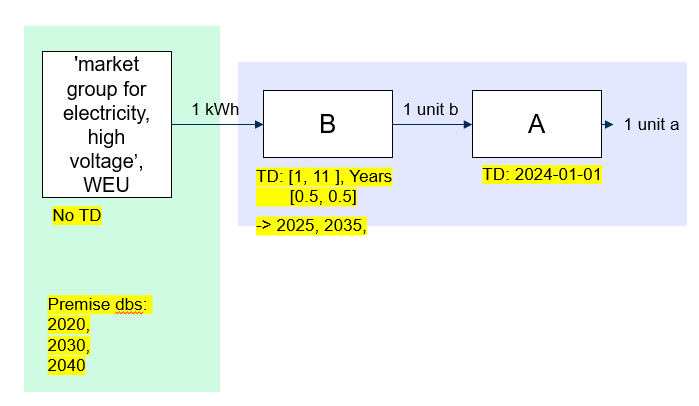
<br> <br> 

write foreground db:

In [8]:
bd.Database('foreground').write({
    ('foreground', 'A'): {
        'name': 'process A',
        'exchanges': [
            {
                'amount': 1,
                'type': 'production',
                'input': ('foreground', 'A'),
            },
            {
                'amount': 1,
                'type': 'technosphere',
                'input': ('foreground', 'B'),
                'temporal_distribution': TemporalDistribution(
                    np.array([1, 11], dtype='timedelta64[Y]'),
                    np.array([0.5, 0.5]
)),  
            },
        ]
    },
    ('foreground', 'B'):
    {
        "name": "process B",
        "exchanges": [
             {
                'amount': 1,
                'type': 'technosphere',
                'input': ((electr_WEU_2020["database"], electr_WEU_2020["code"])), # market group for electricity, high voltage' (kilowatt hour, WEU, None)
                                          }
        ]

    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]

Vacuuming database 


In [9]:
bd.databases

Databases dictionary with 6 object(s):
	biosphere3
	cutoff39
	db_2020
	db_2030
	db_2040
	foreground

In [10]:
# checking foreground links
for act in bd.Database('foreground'):
    print(act)
    for exc in act.technosphere():
        print(exc, exc.input["database"])
       

'process B' (None, None, None)
Exchange: 1 kilowatt hour 'market group for electricity, high voltage' (kilowatt hour, WEU, None) to 'process B' (None, None, None)> db_2020
'process A' (None, None, None)
Exchange: 1 None 'process B' (None, None, None) to 'process A' (None, None, None)> foreground


select method:

In [11]:
CC_method = [m for m in bd.methods if 'IPCC 2021' in str(m) and  'climate change no LT' in str(m) and 'GWP100' in str(m) and 'no LT' in str(m)][0]
CC_method

('IPCC 2021 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

### Standard medusa LCA from here on:

In [12]:
from datetime import datetime

database_date_dict = {
    "db_2020": datetime.strptime("2020", "%Y"),
    "db_2030": datetime.strptime("2030", "%Y"),
    "db_2040": datetime.strptime("2040", "%Y"),
    "cutoff39": datetime.strptime("2020", "%Y"), # all databases need to have a corresponding time
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

In [13]:
SKIPPABLE = [node.id for node in bd.Database('db_2020')] + [
    node.id for node in bd.Database('db_2030')] + [
    node.id for node in bd.Database('db_2040')] + [
    node.id for node in bd.Database('cutoff39')
    ] 

def filter_function(database_id: int) -> bool:
    return database_id in SKIPPABLE

len(SKIPPABLE)

93570

In [14]:
demand = {('foreground', 'A'): 1}
method = CC_method

In [15]:
demand = {("foreground",'A'): 1}
slca=bc.LCA(demand,CC_method)
slca.lci()
slca.lcia()
print(f'Static LCA score: {slca.score}')

Static LCA score: 0.34579846666257064


In [16]:
from medusa import MedusaLCA
mlca = MedusaLCA(demand, method, filter_function, database_date_dict, max_calc=2) #aborted after 100 min for max_calc = 5000


Starting graph traversal
Calculation count: 4


c:\Users\MULLERA\AppData\Local\anaconda3\envs\tictac\lib\site-packages\bw_graph_tools\graph_traversal.py:403: UserWarning: Stopping traversal due to calculation count.
  warnings.warn("Stopping traversal due to calculation count.")


#TODO understand why traversal takes so long despite skippable

In [ ]:
import warnings
warnings.filterwarnings("ignore")
mlca.build_timeline()

In [ ]:
mlca.timeline_builder

: 

In [ ]:
mlca.build_datapackage()
mlca.lci()
mlca.lcia()

UnknownObject: 

In [ ]:
print('Old static LCA Score:', mlca.static_lca.score)
print('New MEDUSA LCA Score:', mlca.score)

In [ ]:
mlca.dynamic_inventory

compare with prospective-dynamic score with expected results

In [ ]:
# compare with expected results: tiny deviation is fine!

# expected lca results from 1 kWh electricty WEU 2020
lca_electr_WEU_2020=bc.LCA({(electr_WEU_2020["database"],electr_WEU_2020["code"]): 1},CC_method)
lca_electr_WEU_2020.lci()
lca_electr_WEU_2020.lcia()
score_2020 = lca_electr_WEU_2020.score

# expected lca results from 1 kWh electricty WEU 2030
lca_electr_WEU_2030=bc.LCA({(electr_WEU_2030["database"],electr_WEU_2030["code"]): 1},CC_method)
lca_electr_WEU_2030.lci()
lca_electr_WEU_2030.lcia()
score_2030 = lca_electr_WEU_2030.score

# expected lca results from 1 kWh electricty WEU 2040
lca_electr_WEU_2040=bc.LCA({(electr_WEU_2040["database"],electr_WEU_2040["code"]): 1},CC_method)
lca_electr_WEU_2040.lci()
lca_electr_WEU_2040.lcia()
score_2040 = lca_electr_WEU_2040.score

#expected score according to temporal distributions
expected_score=0.5*(0.5*score_2020+0.5*score_2030) + 0.5*(0.5*score_2030+0.5*score_2040)
delta=expected_score-mlca.score
print(f"Difference between medusa score and expected score {delta}")

Difference between medusa score and expected score 2.1680213180275132e-11


### some more matrix explorations:

In [ ]:
columns= mlca.technosphere_matrix.shape[1]
print(f"length of technosphere matrix: {columns}")	

length of technosphere matrix: 94247


In [ ]:
mlca.technosphere_matrix[:,1].data
mlca.biosphere_matrix[:,1].data

array([3.78812024e-06, 1.54677455e-05, 3.78812024e-06, 1.62712411e-06,
       7.73400814e-07, 2.24487706e-10, 8.34675218e-10, 5.00893726e-08,
       4.48975413e-07, 1.17062306e+00, 1.85466241e-04, 1.80775501e-07,
       4.65752148e-09, 5.54788244e-07, 7.16002774e-07, 1.52865147e-13,
       7.73400825e-06, 1.16010824e-05, 1.54677455e-05, 7.73400814e-07,
       1.54677451e-07, 6.74959722e-07, 4.50472015e-07, 5.21276775e-07,
       1.74362185e-07, 2.24487717e-09, 7.73400825e-05, 7.73400825e-06,
       1.20468655e-07, 4.27906707e-06, 2.65389577e-08, 9.50542526e-05,
       7.73400814e-07, 7.92556065e-08, 4.48975425e-06, 6.46482874e-03,
       1.54857025e-05, 1.04139335e-01, 3.80426457e-07, 9.24754702e-03,
       9.40753040e-08, 2.59667395e-05, 4.29655866e-09, 3.61256883e-04,
       4.50437376e-08, 3.53141183e-09, 2.84011203e-05, 3.73352549e-08,
       1.46598722e-06, 3.00175134e-06, 5.48461855e-07, 5.17290027e-06,
       5.30319267e-06, 1.85680278e-06, 7.37473798e-08, 5.29704529e-08,
      

In [ ]:
#new keys added by medusa
all_keys = mlca.dicts.activity.reversed

new_keys = {key: value for key, value in all_keys.items() if value > 100000}
new_keys

{94241: 500692021,
 94242: 500692024,
 94243: 989492021,
 94244: 989492024,
 94245: 989502021,
 94246: 989502024}

In [ ]:
mlca.remapping_dicts['activity']

{3775: ('biosphere3', '00012c0a-9bff-4787-a7eb-56c3d2f43692'),
 4077: ('biosphere3', '00143719-33a7-5738-aa1b-131f97b4fef3'),
 2765: ('biosphere3', '0015315d-a2b8-4b72-8e60-0d34a72e6de8'),
 286: ('biosphere3', '0015ec22-72cb-4af1-8c7b-0ba0d041553c'),
 3084: ('biosphere3', '0017271e-7df5-40bc-833a-36110c1fe5d5'),
 2124: ('biosphere3', '001790f3-fd86-4a0d-a2a1-06c7099d90c8'),
 3688: ('biosphere3', '0017ce28-9f7a-404b-ad55-d3f43ad13cae'),
 4475: ('biosphere3', '004dbd05-6759-507a-a7f6-9f288706a1cd'),
 1401: ('biosphere3', '0061b12a-9084-499b-9fc0-bf66025198eb'),
 1988: ('biosphere3', '006aa3f7-59ba-450f-aa45-a2b2d1752647'),
 2423: ('biosphere3', '007de693-1d9e-40a5-a8b4-3d11bce8be9a'),
 817: ('biosphere3', '00907a61-b501-4f47-b688-1dc2b51d48c1'),
 4680: ('biosphere3', '0097bf60-3729-40b6-94d0-06bd6146cfc2'),
 2622: ('biosphere3', '0098b967-2131-43d2-b684-254583fbadc7'),
 2229: ('biosphere3', '009a49e8-09a7-4432-9cb9-f2dd18e8f922'),
 202: ('biosphere3', '009f3374-e604-4e24-88f5-d785cd93aac

In [ ]:
mlca.remapping_dicts['product']

{3775: ('biosphere3', '00012c0a-9bff-4787-a7eb-56c3d2f43692'),
 4077: ('biosphere3', '00143719-33a7-5738-aa1b-131f97b4fef3'),
 2765: ('biosphere3', '0015315d-a2b8-4b72-8e60-0d34a72e6de8'),
 286: ('biosphere3', '0015ec22-72cb-4af1-8c7b-0ba0d041553c'),
 3084: ('biosphere3', '0017271e-7df5-40bc-833a-36110c1fe5d5'),
 2124: ('biosphere3', '001790f3-fd86-4a0d-a2a1-06c7099d90c8'),
 3688: ('biosphere3', '0017ce28-9f7a-404b-ad55-d3f43ad13cae'),
 4475: ('biosphere3', '004dbd05-6759-507a-a7f6-9f288706a1cd'),
 1401: ('biosphere3', '0061b12a-9084-499b-9fc0-bf66025198eb'),
 1988: ('biosphere3', '006aa3f7-59ba-450f-aa45-a2b2d1752647'),
 2423: ('biosphere3', '007de693-1d9e-40a5-a8b4-3d11bce8be9a'),
 817: ('biosphere3', '00907a61-b501-4f47-b688-1dc2b51d48c1'),
 4680: ('biosphere3', '0097bf60-3729-40b6-94d0-06bd6146cfc2'),
 2622: ('biosphere3', '0098b967-2131-43d2-b684-254583fbadc7'),
 2229: ('biosphere3', '009a49e8-09a7-4432-9cb9-f2dd18e8f922'),
 202: ('biosphere3', '009f3374-e604-4e24-88f5-d785cd93aac

In [ ]:
len(mlca.remapping_dicts['biosphere'])

98950